# Fannie Mae Mortgae data analysis with H2O 

![](fannie.png)

This notebook contains code to analyse mortgage data, in particular the so-called Single-Family Fixed Rate mortgaes. See the following link how to download data and [more details](https://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html).

Per quarter there is a Acquisition data set and a Performance data set. See the [details here](https://www.fanniemae.com/resources/file/fundmarket/pdf/webinar-101.pdf)

When you download the data from the web site, it is a zip file per quarter that contains an aquisition.txt and a performance.txt file. That is not so handy fro importing the data, I want to zip all the performance.txt files in one zip file and all the acquistion.txt files in another zip file.

You can do that with the following commands, so having downloaded the 20**.zip files in a directory:

`unzip '*.zip'`

`zip acquisition.zip Acq*.txt`

`zip performances.zip Perf*.txt`

The unzipped txt files are not needed anymore, I am making use of h2o, which can import zipped text files directly.

`rm *.txt`

Doing this for the years 2010 and 2011, results in an acquisition.zip file of 85 MB and a performance.zip file of 2.4 GB. When you download more or all the quarters from the fanniemae website, there might be too much data for your laptop too handle. You may need to spin up a "super computer" on a cloud platform, say GCP, my favourite :-)

In [4]:
## imports
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import h2o

In [5]:
%%capture

#### Set up h2o
h2o.init(max_mem_size="12G");

## Acquisition data
Each row in the acquistion file is a mortage.

### Import from zip

In [6]:
%%time
acquisitions_Variables = [
    "LOAN_ID", "ORIG_CHN", "Seller_Name", "ORIG_RT", "ORIG_AMT", "ORIG_TRM", "ORIG_DTE",
    "FRST_DTE", "OLTV", "OCLTV", "NUM_BO", "Debt_to_Income", "Borrower_Credit_Score", "FTHB_FLG", "PURPOSE", "PROPERTY_TYPE",
    "NUM_UNIT", "OCC_STAT", "STATE", "ZIP_3", "MI_PCT", "Product_Type", "CSCORE_C", "MI_TYPE", "RELOC"
]

acquisition = h2o.import_file(
    "data/acquisition.zip",
    sep = "|",
    header = -1 ,
    col_names = acquisitions_Variables
)

acquisition.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%
CPU times: user 250 ms, sys: 54 ms, total: 304 ms
Wall time: 18.3 s


(3528938, 25)

### some explorations

In [13]:
#### first five records
acquisition.head(5)

LOAN_ID,ORIG_CHN,Seller_Name,ORIG_RT,ORIG_AMT,ORIG_TRM,ORIG_DTE,FRST_DTE,OLTV,OCLTV,NUM_BO,Debt_to_Income,Borrower_Credit_Score,FTHB_FLG,PURPOSE,PROPERTY_TYPE,NUM_UNIT,OCC_STAT,STATE,ZIP_3,MI_PCT,Product_Type,CSCORE_C,MI_TYPE,RELOC
1.0001e+11,C,"WELLS FARGO BANK, N.A.",4.875,284000,360,01/2010,03/2010,80,80,1,32,773,Y,P,PU,1,P,TX,787,nan,FRM,nan,nan,N
1.00014e+11,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",4.75,87000,180,12/2009,02/2010,63,63,2,24,770,N,C,SF,1,P,CA,932,nan,FRM,785,nan,N
1.0002e+11,R,OTHER,5,417000,360,11/2009,01/2010,43,43,2,21,806,N,P,PU,1,S,FL,342,nan,FRM,808,nan,N
1.00022e+11,R,OTHER,5.25,461000,360,01/2010,03/2010,61,61,1,50,682,Y,P,SF,2,P,NY,112,nan,FRM,nan,nan,N
1.00023e+11,R,"WELLS FARGO BANK, N.A.",5.25,100000,360,11/2009,01/2010,80,80,1,39,804,N,P,CO,1,P,OH,446,nan,FRM,nan,nan,N


In [33]:
### count number mortgages per state
states = h2o.as_list(
    acquisition
    .group_by(["STATE"])
    .count()
    .get_frame()
)

In [55]:
### display on map
fig = px.choropleth(
    states,
    locations="STATE",
    locationmode="USA-states",
    color="nrow",
    hover_name="STATE", # column to add to hover information
    color_continuous_scale=px.colors.sequential.Plasma,
    scope="usa",
    width=1200,
    title = "Number of 2010/11 mortgages per state"
)
fig

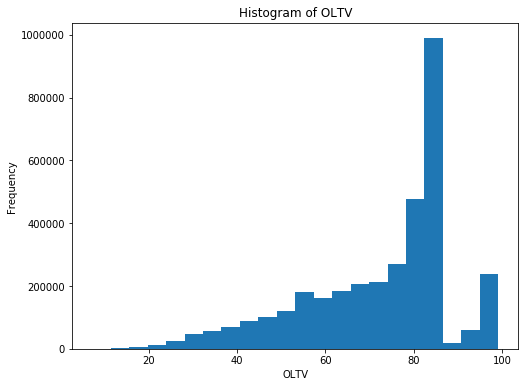

In [54]:
plt.figure(figsize=(8,6))
acquisition["OLTV"].hist()

## Performance data

Each record in this data corresponds to the monthly 'performance' of a mortgage, so for each mortgage in the acquisition data set, there are multiple records in the performance data set. From the start of the mortgage up until end of 2019


### Import from zip

In [7]:
%%time

#### Import performance data
## we do not use all the 31 variables only four variables and the rest is skipped
## only the month delinquency status and the foreclosure date (if any) per mortgage
performance_Variables = [
    "LOAN_ID", "Monthly_Rpt_Prd", "Delq_Status", "Foreclosure_date"
]

performance = h2o.import_file(
    "data/performances.zip",
    sep = "|",
    header = 0 ,
    col_names = performance_Variables,
    skipped_columns=[2,3,4,5,6,7,8,9,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
)

performance.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%
CPU times: user 2.12 s, sys: 458 ms, total: 2.58 s
Wall time: 5min 21s


(204933563, 4)

### Some explorations


In [10]:
#### How many foreclosures are there?
tfcl = performance["Foreclosure_date"].isna()
foreclosures = performance[~tfcl,:]
foreclosures.shape

(10084, 4)

A mortgage that goes into foreclosure usually has a series of 'loan delinquencies'. This can be seen in the column `Delq_Status`. Take for example the following mortgage, everything seemed to be fine up until 2017-04-01, where all of a sudden the mortgage showed delinquencies

In [11]:
tmp = performance [performance["LOAN_ID"] == 102788180928,:]
tmp.tail(15)

LOAN_ID,Monthly_Rpt_Prd,Delq_Status,Foreclosure_date
1.02788e+11,2016-12-01 00:00:00,0,
1.02788e+11,2017-01-01 00:00:00,0,
1.02788e+11,2017-02-01 00:00:00,0,
1.02788e+11,2017-03-01 00:00:00,0,
1.02788e+11,2017-04-01 00:00:00,0,
1.02788e+11,2017-05-01 00:00:00,1,
1.02788e+11,2017-06-01 00:00:00,2,
1.02788e+11,2017-07-01 00:00:00,3,
1.02788e+11,2017-08-01 00:00:00,4,
1.02788e+11,2017-09-01 00:00:00,5,


the values of the column `Delq_Status` have the following meaning:

* 0 - "Current or less than 30 days past due"
* 1 - "30 - 59 days past due"
* 2 - "60 - 89 days past due"
* 3 - "90 - 119 days past due"
* 4 - "120 - 149 days past due"
* 5 - "150 - 179 days past due"
* 6 - "180 Day Delinquency"
* 7 - "210 Day Delinquency"
* 8 - "240 Day Delinquency"
* 9 - "270 Day Delinquency" / "270+ Day Delinquency"

The following code shows an distribution of delinquency status


In [8]:
del_status = h2o.as_list(
    performance
    .group_by(["Delq_Status"])
    .count()
    .get_frame()
)

In [14]:
del_status.query("0 < Delq_Status < 10")

,Delq_Status,nrow
2,1.0,1017152
3,2.0,218914
4,3.0,97951
5,4.0,65857
6,5.0,52771
7,6.0,39927
8,7.0,31939
9,8.0,26562
10,9.0,22307


### Define a foreclosure target

merge the mortgaes in the acquisition data set with the forecloseres and create a target column

In [72]:
mortgages = acquisition.merge(
    foreclosures,
    all_x=True
)

mortgages["TARGET_FC"] = (mortgages["Foreclosure_date"].isna()).ifelse(0,1)


In [87]:
### Fore closure rate around .285%
mortgages["TARGET_FC"].mean()

[0.0028563834218679955]

In [95]:
states_foreclosures = h2o.as_list(
    mortgages
    .group_by(["STATE"])
    .mean(col="TARGET_FC", na="rm")
    .count()
    .get_frame()
)
states_foreclosures = states_foreclosures.assign(FC_percentage = states_foreclosures.mean_TARGET_FC*100)

In [96]:
### display on map
fig = px.choropleth(
    states_foreclosures,
    locations="STATE",
    locationmode="USA-states",
    color="FC_percentage",
    hover_name="STATE", # column to add to hover information
    color_continuous_scale=px.colors.sequential.Plasma,
    scope="usa",
    width=1200,
    title = "Foreclosure percentage of 2010/11 mortgages per state"
)
fig

In [97]:
states_foreclosures.sort_values("FC_percentage", ascending = False)

,STATE,mean_TARGET_FC,nrow,FC_percentage
41,PR,0.011534,10924,1.153424
49,VI,0.010802,648,1.080247
1,AL,0.008876,43603,0.887554
26,MS,0.008072,20070,0.807175
2,AR,0.006656,24340,0.665571
18,KY,0.005738,31542,0.573838
53,WV,0.005626,9599,0.562559
45,TN,0.005557,57769,0.555661
34,NM,0.005272,20296,0.527197
25,MO,0.005164,76493,0.516387


### Delinquency target

We can also look a less severe target, instead of foreclosures we can look at 90 days paymenyt arrears 

In [3]:
h2o.shutdown()

H2O session _sid_a332 closed.
